
keras-recommender
Recommender built using keras

The dataset is taken from [ml-latest-small (MovieLens)](https://grouplens.org/datasets/movielens/)

### Types of collaborative filtering techniques
1. Memory based 
2. Model based <br>
    2.1 Matrix Factorization <br>
    2.2 Clustering <br>
    2.3 Deep Learning <br>
    
 # ![CF](resources/CF.png)
 ![CF](CF.png)

**Matrix Factorization (MF):** The idea behind such models is that attitudes or preferences of a user can be determined by a small number of hidden factors. We can call these factors as Embeddings.

Visualization of matrix factorization

 # ![CF_MF](resources/CF_MF.png)
 ![CF_MF](CF_MF.png)
**Embeddings:**
Intuitively, we can understand embeddings as low dimensional hidden factors for items and users. For e.g. say we have 5 dimensional (i.e. D or n_factors = 5 in above figure) embeddings for both items and users (# 5 chosen randomly). Then for user-X & movie-A, we can say the those 5 numbers might represent 5 different characteristics about the movie, like (i) how much movie-A is sci-fi intense (ii) how recent is the movie (iii) how much special effects are in movie A (iv) how dialogue driven is the movie (v) how CGI driven is the movie. Likewise, 5 numbers in user embedding matrix might represent, (i) how much does user-X like sci-fi movie (ii) how much does user-X like recent movies …and so on. In above figure, a higher number from dot product of user-X and movie-A matrix means that movie-A is a good recommendation for user-X.

**Matrix factorization and embeddings**

![CF_MF](resources/MF_Embeddings.png)

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd


In [2]:
data_dir_path = 'resources/ml-latest-small'

df = pd.read_csv(data_dir_path + '/ratings.csv')
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [3]:
#We assign a unique number between (0, #users) to each user and do the same for movies.
df.userId = df.userId.astype('category').cat.codes.values
df.movieId = df.movieId.astype('category').cat.codes.values

In [4]:
df.head()

,userId,movieId,rating,timestamp
0,0,0,4.0,964982703
1,0,2,4.0,964981247
2,0,5,4.0,964982224
3,0,43,5.0,964983815
4,0,46,5.0,964982931


In [5]:
train, test = train_test_split(df, test_size=0.2, random_state=0)

In [6]:
train.head()

,userId,movieId,rating,timestamp
77701,482,5213,4.0,1215545278
94477,598,5879,2.5,1498518389
36246,246,3814,2.0,1467645405
17483,110,4900,3.5,1516140853
100300,609,6651,4.5,1493847901


In [7]:
test.head()

,userId,movieId,rating,timestamp
41008,275,615,5.0,858350384
94274,598,4970,2.5,1519235950
77380,482,1008,2.5,1215895327
29744,201,2576,3.0,974924072
40462,273,6763,4.0,1296947017


Matrix factorisation
One popular recommender systems approach is called Matrix Factorisation. It works on the principle that we can learn a low-dimensional representation (embedding) of user and movie. For example, for each movie, we can have how much action it has, how long it is, and so on. For each user, we can encode how much they like action, or how much they like long movies, etc. Thus, we can combine the user and the movie embeddings to estimate the ratings on unseen movies. This approach can also be viewed as: given a matrix $(A [M X N])$ containing users and movies, we want to estimate low dimensional matrices $(W [M X k] and H [M X k])$, such that: $A≈W.HT$

In [8]:
import keras
from IPython.display import SVG
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot
n_users, n_movies = len(df.userId.unique()), len(df.movieId.unique())
n_latent_factors = 3

Using TensorFlow backend.


The key thing is to learn an embedding for movies and users, and then combine them using the dot product! For estimating the rating, for each user, movie pair of interest, we'd take the dot product of the respective user and item embedding. As an example, if we have 2 dimensions in our user and item embedding, which say correspond to [how much user likes action, how much user likes long movies], and the item embedding is [how much action is in the movie, how long is the movie]. Then, we can predict for a user u, and movie m as how much u likes action × how much action is there in m + how much u likes long movies × how long is m.

Our model would optimise the emebedding such that we minimise the mean squared error on the ratings from the train set.

In [9]:
movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors, name='Movie-Embedding')(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors,name='User-Embedding')(user_input))

movie_vec.shape
prod = keras.layers.dot([movie_vec, user_vec], axes=-1, normalize=False)
model = keras.Model([user_input, movie_input], prod)
model.compile('adam', 'mean_squared_error')

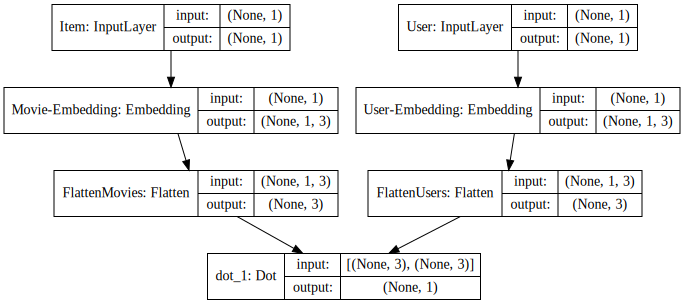

In [10]:
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

We can see that in the dot layer, we take the dot product of the user and the item embeddings to obtain the rating.

We can also summarise our model as follows:

In [11]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 3)         29175       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 3)         1833        User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

In [12]:
history = model.fit([train.userId, train.movieId], train.rating, epochs=100, verbose=0)

Text(0,0.5,'Train Error')

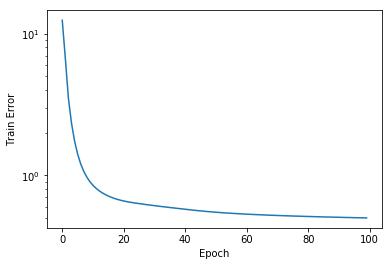

In [14]:
import matplotlib.pyplot as plt
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")

### Prediction
post-processing step to round off our prediction to the nearest integer. This is usually not done, and thus just a whimsical step, since the training ratings are all integers! There are better ways to encode this intger requirement (one-hot encoding!).

In [17]:
import numpy as np
y_hat = np.round(model.predict([test.userId, test.movieId]),0)
y_true = test.rating

In [18]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, y_hat)

0.8071697738992464

### We got MAE of 0.80

#### Extracting the learnt embeddings
We can extract the learnt movie and item embeddings as follows:

In [20]:
movie_embedding_learnt = model.get_layer(name='Movie-Embedding').get_weights()[0]
pd.DataFrame(movie_embedding_learnt).describe()

,0,1,2
count,9725.000000,9725.000000,9725.000000
mean,0.621525,-0.613947,0.607931
std,0.376859,0.329957,0.323711
min,-2.505982,-2.027589,-2.160055
25%,0.403554,-0.831288,0.415429
50%,0.660320,-0.659402,0.650704
75%,0.845942,-0.421031,0.818681
max,3.388693,0.889043,1.949376


In [21]:
user_embedding_learnt = model.get_layer(name='User-Embedding').get_weights()[0]
pd.DataFrame(user_embedding_learnt).describe()

,0,1,2
count,611.000000,611.000000,611.000000
mean,1.680741,-1.746402,1.684900
std,0.902178,0.653797,0.652417
min,-1.748080,-3.898040,-0.857407
25%,1.137757,-2.152076,1.311027
50%,1.651160,-1.800228,1.737987
75%,2.244645,-1.395046,2.090224
max,4.609274,1.703610,4.374075


We can see that both the user and the item embeddings have **negative elements**. There are some applications which require that the learnt embeddings be non-negative. This approach is also called non-negative matrix factorisation(NNMF).